# Cycle Diffusion Implementation

In [8]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image
import os
from pytorch_lightning.callbacks.model_summary import ModelSummary
from pytorch_lightning.utilities.model_summary import summarize
import matplotlib.pyplot as plt

In [ ]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=6, out_channels=3):
        """
        Initializes the ConditionalUNet model.

        Parameters
        ----------
        in_channels : int, optional
            The number of input channels for the UNet. Defaults to 6.
        out_channels : int, optional
            The number of output channels for the UNet. Defaults to 3.

        This UNet consists of an encoder, a middle processing layer, and a decoder.
        The encoder and decoder use convolutional layers with ReLU activations.
        """

        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, out_channels, 3, padding=1)
        )

    def forward(self, x, cond):
        
        """
        Forward pass of the ConditionalUNet model.

        Parameters
        ----------
        x : torch.Tensor
            The input tensor.
        cond : torch.Tensor
            The conditioning tensor.

        Returns
        -------
        torch.Tensor
            The output tensor.
        """
        
        x = torch.cat([x, cond], dim=1)
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

# --- CycleDiffusion LightningModule ---
class CycleDiffusionModule(pl.LightningModule):
    def __init__(self, model_A2B, model_B2A, T=1000, lr=1e-4):
        """
        Initializes the CycleDiffusionModule model.

        Parameters
        ----------
        model_A2B : nn.Module
            The model to map domain A to domain B.
        model_B2A : nn.Module
            The model to map domain B to domain A.
        T : int, optional
            The number of time steps. Defaults to 1000.
        lr : float, optional
            The learning rate for the optimizer. Defaults to 1e-4.

        The model consists of two conditional UNet models, one for each direction
        of the cycle. The models are used to predict noise that is used to
        condition the diffusion process. The `betas`, `alphas`, and
        `alphas_cumprod` are registered as buffers to store the time-dependent
        noise schedules.
        """
        super().__init__()
        self.model_A2B = model_A2B
        self.model_B2A = model_B2A
        self.T = T
        self.lr = lr

        beta_start, beta_end = 1e-4, 0.02
        betas = torch.linspace(beta_start, beta_end, T)
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_cumprod', alphas_cumprod)

    def q_sample(self, x_start, t, noise):
        """
        Sample from the q(x_t | x_0) distribution.

        Parameters
        ----------
        x_start : torch.Tensor
            The starting image.
        t : int or torch.Tensor
            The time step(s) to sample from.
        noise : torch.Tensor
            The noise to add to the output.

        Returns
        -------
        x_noisy : torch.Tensor
            The noisy image.
        """
        sqrt_alphas_cumprod = self.alphas_cumprod[t].sqrt().view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod = (1 - self.alphas_cumprod[t]).sqrt().view(-1, 1, 1, 1)
        return sqrt_alphas_cumprod * x_start + sqrt_one_minus_alphas_cumprod * noise

    def training_step(self, batch, batch_idx):
        """
        The training step for the CycleDiffusion model.

        Parameters
        ----------
        batch : torch.Tensor
            A tuple of hazy and clear images.
        batch_idx : int
            The index of the current batch.

        Returns
        -------
        loss : torch.Tensor
            The total loss for the current batch.
        """
        hazy, clear = batch
        t = torch.randint(0, self.T, (hazy.size(0),), device=self.device)
        noise = torch.randn_like(clear)

        # A → B (Hazy → Clear)
        noisy_clear = self.q_sample(clear, t, noise)
        pred_noise_A2B = self.model_A2B(noisy_clear, hazy)
        loss_A2B = nn.MSELoss()(pred_noise_A2B, noise)

        # Reconstruct A (Clear → Hazy → Clear)
        clear_recon = self.q_sample(clear, t, noise)
        hazy_hat = self.model_B2A(clear_recon, clear)
        hazy_cycle = self.model_A2B(clear_recon, hazy_hat)
        cycle_loss = nn.L1Loss()(clear, hazy_cycle)

        loss = loss_A2B + cycle_loss
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        """
        Configure the optimizers for the CycleDiffusion model.

        Returns
        -------
        torch.optim.Adam
            The Adam optimizer with the learning rate set to self.lr.
        """
        return torch.optim.Adam(self.parameters(), lr=self.lr)

# --- Real Image Dataset ---
class RealHazyDataset(Dataset):
    def __init__(self, hazy_dir, clear_dir, image_size=128):
        """
        Initialize the RealHazyDataset.

        Parameters
        ----------
        hazy_dir : str
            The directory containing the hazy images.
        clear_dir : str
            The directory containing the clear images.
        image_size : int, optional
            The size of the resized images. Defaults to 128.
        """
        self.hazy_paths = sorted([os.path.join(hazy_dir, f) for f in os.listdir(hazy_dir) if f.endswith(('.jpg', '.png'))])
        self.clear_paths = sorted([os.path.join(clear_dir, f) for f in os.listdir(clear_dir) if f.endswith(('.jpg', '.png'))])
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return min(len(self.hazy_paths), len(self.clear_paths))

    def __getitem__(self, idx):
        hazy_img = self.transform(Image.open(self.hazy_paths[idx]).convert('RGB'))
        clear_img = self.transform(Image.open(self.clear_paths[idx]).convert('RGB'))
        return hazy_img, clear_img


In [ ]:
path = "/your/path/to/directory"

In [7]:

# Create dataset and dataloader
hazy_dir = path+"/Consolidated_Hazy_Images"
clear_dir = path+"/Consolidated_Clear_Images"

In [11]:
model_A2B = ConditionalUNet()
model_B2A = ConditionalUNet()
cycle_diffusion = CycleDiffusionModule(model_A2B, model_B2A)

dataset = RealHazyDataset(hazy_dir, clear_dir)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

trainer = pl.Trainer(max_epochs=5, accelerator='auto')

print(summarize(cycle_diffusion, max_depth=1))

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  | Name      | Type            | Params | Mode 
------------------------------------------------------
0 | model_A2B | ConditionalUNet | 300 K  | train
1 | model_B2A | ConditionalUNet | 300 K  | train
------------------------------------------------------
600 K     Trainable params
0         Non-trainable params
600 K     Total params
2.404     Total estimated model params size (MB)
26        Modules in train mode
0         Modules in eval mode


In [17]:
trainer.fit(cycle_diffusion,dataloader)

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


# Metrics

In [ ]:
import numpy as np
from scipy import signal

def compute_fade(image):
    # Convert image to grayscale if it's not already
    """
    Compute the FADE score of an image.

    The FADE score is a metric that measures the difference between the original
    image and the dehazed image. The score is computed as the mean of the NSS
    features of the absolute difference between the original image and its
    local mean.

    Parameters
    ----------
    image : array_like
        The image to compute the FADE score for.

    Returns
    -------
    float
        The FADE score of the image.
    """
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute local contrast
    kernel = np.ones((3, 3)) / 9
    local_mean = signal.convolve2d(image, kernel, mode='same')
    local_contrast = np.abs(image - local_mean)

    # Compute NSS features
    nss_features = compute_nss_features(local_contrast)

    # Compute FADE score (this is a simplified version)
    fade_score = np.mean(nss_features)

    return fade_score

def compute_nss_features(local_contrast):
    # This is a placeholder for the actual NSS feature computation
    # In practice, this would involve more complex calculations
    """
    Compute Natural Scene Statistics (NSS) features from local contrast.

    This function serves as a placeholder for computing NSS features from the
    local contrast of an image. NSS features are statistical measures of the
    image that are useful in image quality assessment and other image processing
    tasks.

    Parameters
    ----------
    local_contrast : array_like
        The local contrast of the image, typically computed as the absolute
        difference between the image and its local mean.

    Returns
    -------
    array_like
        The NSS features derived from the local contrast. In this placeholder,
        it simply returns the local contrast as the NSS features.
    """
    return local_contrast

In [ ]:
import numpy as np
from scipy import ndimage

def compute_jnbm(image):
    # Convert image to grayscale if it's not already
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)

    # Compute edge map
    edge_map = compute_edge_map(image)

    # Compute local contrast
    local_contrast = compute_local_contrast(image)

    # Compute JNB at each edge pixel
    jnb = compute_jnb(local_contrast)

    # Compute blur ratio at each edge pixel
    blur_ratio = compute_blur_ratio(edge_map, jnb)

    # Compute final JNBM score
    jnbm_score = np.mean(blur_ratio)

    return jnbm_score

def compute_edge_map(image):
    # Placeholder for edge detection
    return ndimage.sobel(image)

def compute_local_contrast(image):
    # Placeholder for local contrast computation
    return np.abs(image - ndimage.uniform_filter(image, size=3))

def compute_jnb(local_contrast):
    # Placeholder for JNB computation
    return 5 / (1 + np.exp(-0.5 * local_contrast))

def compute_blur_ratio(edge_map, jnb):
    # Placeholder for blur ratio computation
    return np.where(edge_map > 0, edge_map / jnb, 0)

In [ ]:
import numpy as np
from scipy import ndimage

def compute_rea(original_image, restored_image):
    # Convert images to grayscale if they're not already
    if len(original_image.shape) == 3:
        original_image = np.mean(original_image, axis=2)
    if len(restored_image.shape) == 3:
        restored_image = np.mean(restored_image, axis=2)

    # Compute edge maps
    original_edges = compute_edge_map(original_image)
    restored_edges = compute_edge_map(restored_image)

    # Compute visible edges ratio
    visible_edges_ratio = compute_visible_edges_ratio(original_edges, restored_edges)

    # Compute REA score
    rea_score = np.mean(visible_edges_ratio)

    return rea_score

def compute_edge_map(image):
    # Placeholder for edge detection
    return ndimage.sobel(image)

def compute_visible_edges_ratio(original_edges, restored_edges):
    # Placeholder for visible edges ratio computation
    return np.where(original_edges > 0, restored_edges / original_edges, 0)

In [18]:
import os
import numpy as np
from skimage import io
import cv2
from PIL import Image

def calculate_metrics(original_path, generated_path):
    fade_values = []
    jnbm_values = []
    rea_values = []

    # Iterate through the images in both directories
    for filename in os.listdir(original_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read the original and generated images
            original_img = io.imread(os.path.join(original_path, filename))
            generated_img = io.imread(os.path.join(generated_path, f'clear_{filename}'))

            # Convert NumPy array to PIL Image for resizing
            original_img_pil = Image.fromarray(original_img)
            generated_img_pil = Image.fromarray(generated_img)

            # Resize images to 256x256
            original_img_resized = original_img_pil.resize((256, 256))
            generated_img_resized = generated_img_pil.resize((256, 256))

            # Convert images back to NumPy arrays
            original_img_resized = np.array(original_img_resized)
            generated_img_resized = np.array(generated_img_resized)

            # Convert images to grayscale if they're not already
            if len(original_img_resized.shape) == 3:
                original_img_resized = cv2.cvtColor(original_img_resized, cv2.COLOR_RGB2GRAY)
            if len(generated_img_resized.shape) == 3:
                generated_img_resized = cv2.cvtColor(generated_img_resized, cv2.COLOR_RGB2GRAY)

            # Calculate metrics
            fade = compute_fade(generated_img_resized)
            jnbm = compute_jnbm(generated_img_resized)
            rea = compute_rea(original_img_resized, generated_img_resized)

            # Append values to lists
            fade_values.append(fade)
            jnbm_values.append(jnbm)
            rea_values.append(rea)

    # Calculate averages
    avg_fade = np.mean(fade_values)
    avg_jnbm = np.mean(jnbm_values)
    avg_rea = np.mean(rea_values)

    return avg_fade, avg_jnbm, avg_rea

# Paths to the original and generated image directories
original_path = path+"/Consolidated_Test_Clips"
generated_path = path+"/cyclegan_diffusion"

# Calculate average metrics
avg_fade, avg_jnbm, avg_rea = calculate_metrics(original_path, generated_path)

print(f"Average FADE: {avg_fade:.4f}")
print(f"Average JNBM: {avg_jnbm:.4f}")
print(f"Average REA: {avg_rea:.4f}")


Average FADE: 4.986
Average JNBM: 54.632
Average REA: 4.621


Give the path to the hazy image: /content/drive/MyDrive/Vikram/gen AI Project/Consolidated_Hazy_Images/TLH_10_TLH_10_1002.png
Give the output directory: /content
Processed image saved as /content/clear_TLH_10_TLH_10_1002.png


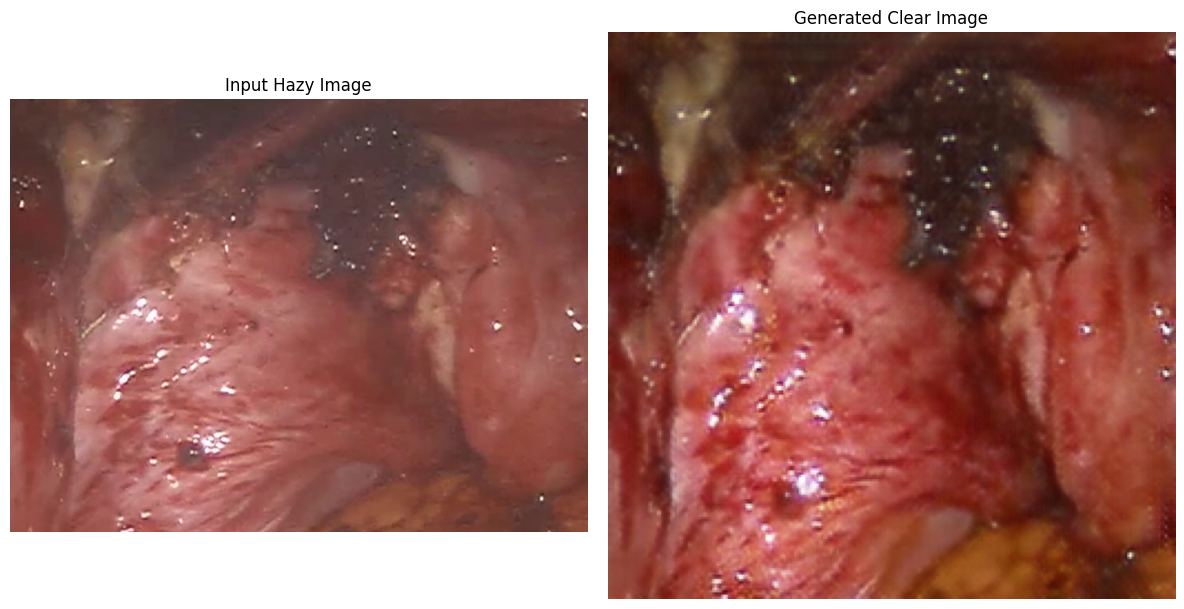

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt

def process_single_image(model, input_path, output_dir):
    """
    Processes a single hazy image using a given model to generate and save a clear image.

    This function takes a hazy image file, applies a series of transformations, and 
    uses the provided model to generate a clear image. The processed clear image is 
    saved in the specified output directory with a 'clear_' prefix. Additionally, 
    the function displays the input hazy image and the generated clear image side by side.

    Parameters
    ----------
    model : torch.nn.Module
        The pre-trained model used for generating the clear image.
    input_path : str
        The file path to the input hazy image.
    output_dir : str
        The directory where the generated clear image will be saved.

    Returns
    -------
    PIL.Image.Image
        The generated clear image as a PIL Image.
    matplotlib.figure.Figure
        The matplotlib Figure containing the displayed images.
    """

    model.eval()
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        hazy_img = Image.open(input_path).convert('RGB')
        hazy_tensor = test_transform(hazy_img).unsqueeze(0).to(model.device)

        clear_img = model(hazy_tensor)

        # Convert tensor to image
        clear_img_np = (clear_img.squeeze().cpu().numpy().transpose(1, 2, 0) + 1) / 2
        clear_img_np = np.clip((clear_img_np * 255), 0, 255).astype('uint8')
        clear_img_pil = Image.fromarray(clear_img_np)

        # Save the output image
        output_filename = f'clear_{os.path.basename(input_path)}'
        output_path = os.path.join(output_dir, output_filename)
        clear_img_pil.save(output_path)

        print(f"Processed image saved as {output_path}")

        # Display input and output images
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(hazy_img)
        plt.title("Input Hazy Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(clear_img_np)
        plt.title("Generated Clear Image")
        plt.axis('off')

        plt.tight_layout()

    return clear_img_pil, plt.gcf()  # Return the figure instead of showing it


input_path = input("Give the path to the hazy image: ")
output_dir = input("Give the output directory: ")

clear_img, fig = process_single_image(model, input_path, output_dir)
plt.show()